# Define Spatial Extent of Project

This notebook retrieves Metropolitan Council's 2020 boundaries of the Twin Cities area and extracts the Minneapolis's boundary and buffers 8 kilometers (large emissions were [shown to travel this distance](https://plumepgh.org/model_data.html) if the wind blows right). Both Minneapolis and the Extent are saved in geodatabase.

Output Coordinate Reference System: UTM 15N - EPSG:26915

Source: https://gisdata.mn.gov/dataset/us-mn-state-metc-bdry-census2020counties-ctus

Metadata: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/bdry_census2020counties_ctus/metadata/metadata.html


In [15]:
### Import Packages

# File manipulation

import os # For working with Operating System
import shutil # For deleting folders
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects

# Database 

import psycopg2

# Analysis

import pandas as pd # Data Management
import geopandas as gpd # Spatial Data Manipulation

# Get CWD

cwd = os.getcwd()

In [2]:
### Definitions

def extract_zip_from_url(url=None, savepath=None):
    '''Extract a zipfile from the internet
    then unpack it in to it's own folder 
    within the working directory.
    Takes a single url (string).'''

    if not os.path.exists(savepath):
        os.makedirs(savepath)
    # Unload zip into the new folder
    response = urllib.request.urlopen(url) # Get a response
    zip_folder = zipfile.ZipFile(BytesIO(response.read())) # Read Response
    zip_folder.extractall(path=savepath) # Extract files
    zip_folder.close() # Close zip object

In [3]:
# Download Data

## Twin Cities Metro Boundaries - Downloaded from MN GeospatialCommons gisdata.mn.gov  (~ 5mb)

url = "https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_metc/bdry_census2020counties_ctus/shp_bdry_census2020counties_ctus.zip"

# Create folder name for file
folder_name = 'shp_bdry_census2020counties_ctus' # url.split('/')[-1][:-4] <- programatic way to get foldernam
# Define path for downloaded files
savepath = os.path.join(cwd, '..', '..', 'Data', folder_name)

extract_zip_from_url(url, savepath)

In [4]:
# Read & Select

# Get path

filename = 'Census2020CTUs.shp'
path = os.path.join(savepath, filename)

ctus_boundaries = gpd.read_file(path)

# Select Minneapolis

mpls_boundary = ctus_boundaries[ctus_boundaries['CTU_NAME'] == 'Minneapolis']

# # Write the selected features to a new featureclass
# arcpy.management.CopyFeatures(mpls_boundary, "mpls_boundary")

<Axes: >

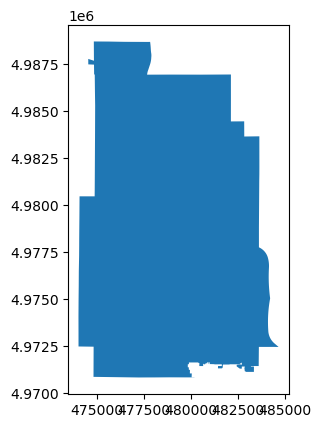

In [5]:
mpls_boundary.plot()

In [6]:
# # Buffer

# buffed_boundary = mpls_boundary.buffer(8000)

In [7]:
# # Save locally as geojsons

# datapath = os.path.join(cwd, '..', '..', 'Data')

# mpls_boundary.to_file(os.path.join(datapath, 'mpls_boundary.geojson'))
# buffed_boundary.to_file(os.path.join(datapath, 'extent.geojson'))

## For Database

In [18]:
# Upload to Database

from dotenv import load_dotenv # Loading .env info

# Get credentials

load_dotenv() # Load .env file

creds = [os.getenv('DB_NAME'),
         os.getenv('DB_USER'),
         os.getenv('DB_PASS'),
         os.getenv('DB_PORT'),
         os.getenv('DB_HOST')
        ]

pg_connection_dict = dict(zip(['dbname', 'user', 'password', 'port', 'host'], creds)) 

conn = psycopg2.connect(**pg_connection_dict)

# Create Cursor for commands

cur = conn.cursor()

## Redo everything below here

# Insert into table

cols = ['CTU_ID', 'CTU_NAME', 'CTU_CODE', 'geometry'] # Relative columns

for i, row in mpls_boundary[cols].iterrows():

    cur.execute(
        'INSERT INTO "Minneapolis Boundary"("CTU_ID", "CTU_NAME", "CTU_CODE", geometry)'
        'VALUES (%(ctu_id)s, %(ctu_name)s, %(ctu_code)s, ST_Transform(ST_SetSRID(ST_GeomFromText(%(geom)s), 26915),4326)::geometry);',
        {'ctu_id': row[0],
         'ctu_name' : row[1],
         'ctu_code': row[2],
         'geom': row[3].wkt})

    # Commit command

    conn.commit()

# Close cursor

cur.close()

# Close connection

conn.close()